In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow -q
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__


'2.15.0'

In [3]:
model=tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 0s 0us/step


In [4]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [5]:
image=tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/CV/Images/car.jpg')

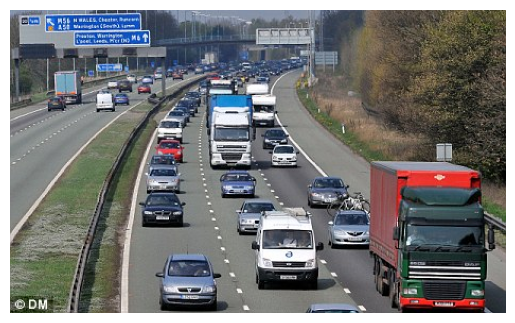

In [6]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [7]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [8]:
image.size

(468, 286)

In [9]:
image=tf.keras.preprocessing.image.img_to_array(image)

In [10]:
image=image/255

In [11]:
image.min(), image.max()

(0.0, 1.0)

In [12]:
import numpy as np
image=np.expand_dims(image, axis=0)

In [13]:
image.shape

(1, 286, 468, 3)

In [14]:
style=tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/CV/Images/tarsila_amaral.jpg')

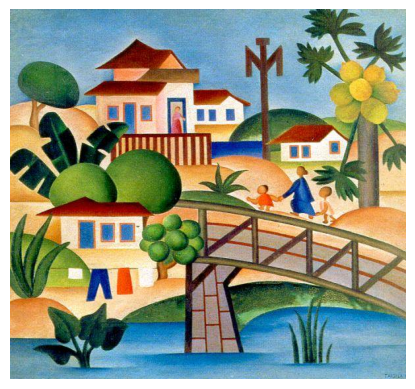

In [15]:
plt.imshow(style)
plt.axis('off')
plt.show()

In [16]:
style=tf.keras.preprocessing.image.img_to_array(style)
style=style/255
style=np.expand_dims(style, axis=0)
style.shape

(1, 560, 600, 3)

In [17]:
style2=tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/CV/Images/vangogh.jpg')

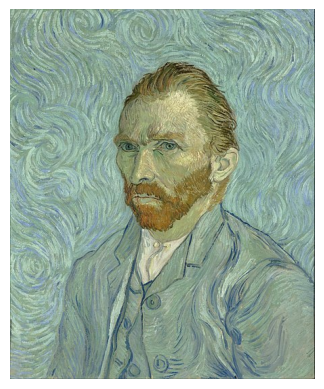

In [18]:
plt.imshow(style2)
plt.axis('off')
plt.show()

In [19]:
style2=tf.keras.preprocessing.image.img_to_array(style2)
style2=style2/255
style2=np.expand_dims(style2, axis=0)
style2.shape

(1, 547, 450, 3)

In [20]:
content_layer=['block4_conv2']
style_layer=['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [21]:
num_content_layers=len(content_layer)
num_style_layers=len(style_layer)

In [22]:
num_content_layers

1

In [23]:
num_style_layers

5

In [24]:
def vgg_layers(layer_names):
  vgg=tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable=False
  outputs=[vgg.get_layer(name).output for name in layer_names]
  model=tf.keras.Model([vgg.input], outputs)
  return model

In [25]:
style_extractor=vgg_layers(style_layer)

In [26]:
style_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [27]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [28]:
style_extractor.outputs[0].shape, style_extractor.outputs[1].shape, style_extractor.outputs[2].shape, style_extractor.outputs[3].shape, style_extractor.outputs[4].shape

(TensorShape([None, None, None, 64]),
 TensorShape([None, None, None, 128]),
 TensorShape([None, None, None, 256]),
 TensorShape([None, None, None, 512]),
 TensorShape([None, None, None, 512]))

In [29]:
style_output=style_extractor(style)

In [30]:
 style_output[0].shape, style_output[1].shape, style_output[2].shape, style_output[3].shape, style_output[4].shape

(TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512]))

In [31]:
def gram_matrix(layer_activation):
  result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
  input_shape = tf.shape(layer_activation)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result / num_locations

In [32]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [33]:
extractor=StyleContentModel(style_layer,content_layer)

In [34]:
results=extractor(image)

In [35]:
for key, value in results.items():
  print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [36]:
style_targets = extractor(style)['style']
content_targets = extractor(image)['content']

In [37]:
new_image = tf.Variable(image)


In [38]:
content_weight = 1
style_weight = 100

In [39]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

In [40]:
expected_output = np.array([10000, 15000])
predictions = np.array([8000, 15900])

In [41]:
np.sum(abs(expected_output - predictions)) / 2

1450.0

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [43]:
mean_absolute_error(expected_output, predictions)

1450.0

In [44]:
mean_squared_error(expected_output, predictions)

2405000.0

Epoch 500 | content loss: 848299.5625 | style loss: 257651024.0 | total loss 5153868800.0


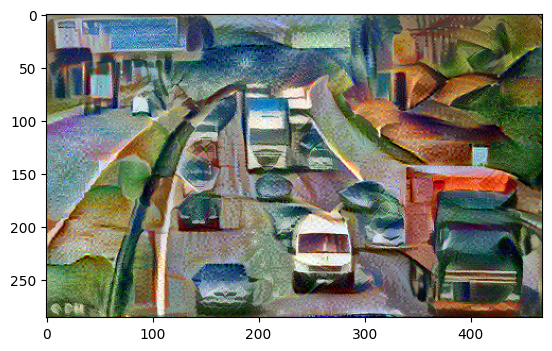

Epoch 1000 | content loss: 882893.5625 | style loss: 292046240.0 | total loss 5841807360.0


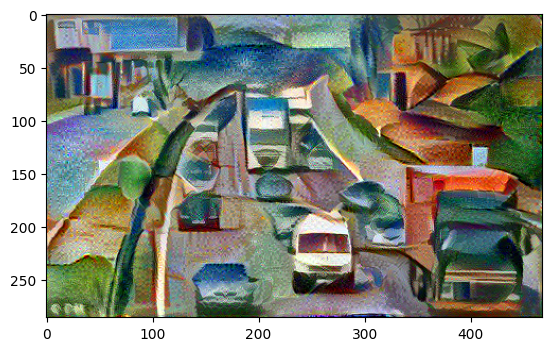

Epoch 1500 | content loss: 906065.0625 | style loss: 145867936.0 | total loss 2918264832.0


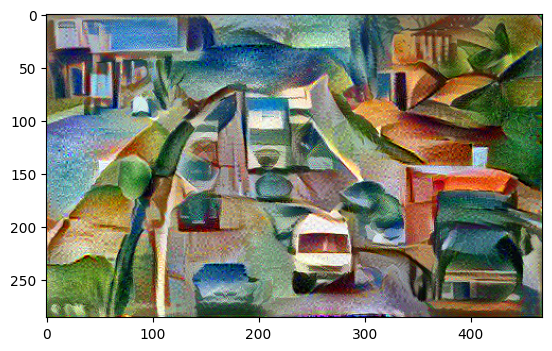

Epoch 2000 | content loss: 922624.0625 | style loss: 160163104.0 | total loss 3204184576.0


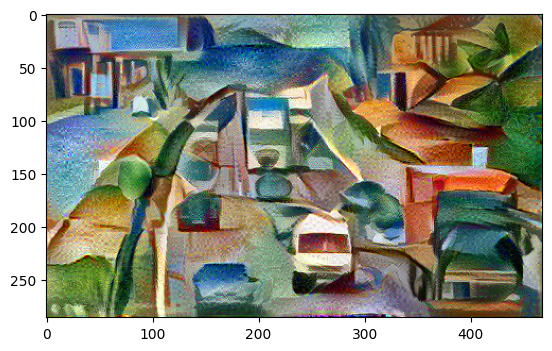

Epoch 2500 | content loss: 938232.375 | style loss: 170624912.0 | total loss 3413436416.0


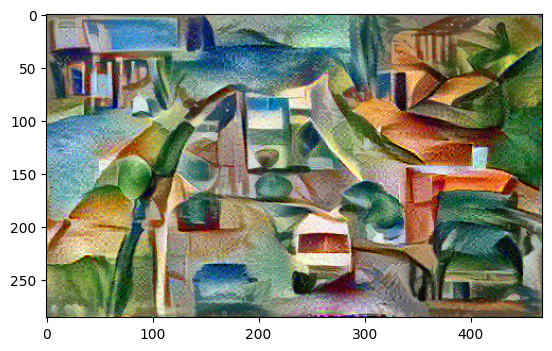

Epoch 3000 | content loss: 951592.0625 | style loss: 109701920.0 | total loss 2194989824.0


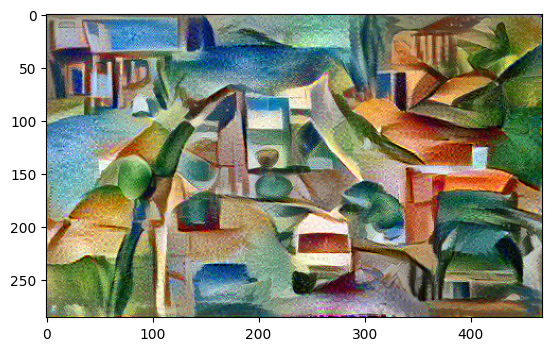

In [45]:
epochs = 3000
print_every = 500

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)

    content_outputs = outputs['content']
    style_outputs = outputs['style']

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

    total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers

  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])

  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

  if (epoch + 1) % print_every == 0:
    print('Epoch {} | content loss: {} | style loss: {} | total loss {}'.format(epoch + 1, content_loss, style_loss, total_loss))
    plt.imshow(tf.squeeze(new_image, axis = 0))
    plt.show()